In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
BATCH_SIZE= 32
IMAGE_SIZE= 256
CHANNELS=3
EPOCHS=50
input_shape= (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)

In [3]:
 dataset = tf.keras.preprocessing.image_dataset_from_directory("PlantVillage",shuffle
                                                              =True,image_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                              batch_size=BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [4]:
class_names= dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

(32, 256, 256, 3)
[1 0 0 1 0 1 1 0 2 0 1 0 0 0 1 1 0 1 1 0 1 0 0 1 2 1 0 1 1 0 0 0]


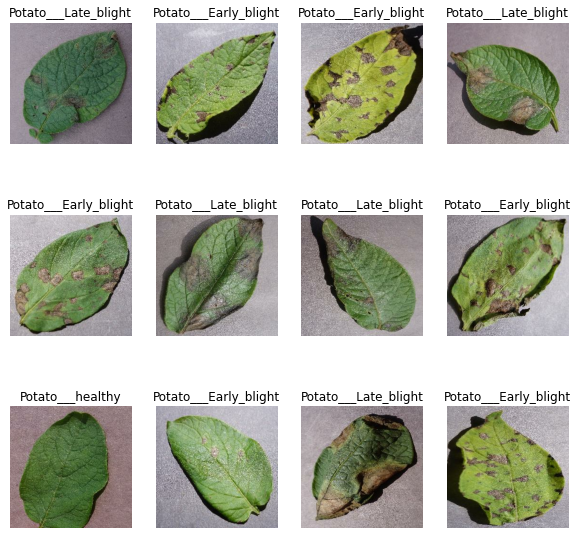

In [5]:
plt.figure(figsize=(10,10))
for image_batch,labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    for i in range(12):
        ax= plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [6]:
# Train --> 80%
# Test  --> 20%
#     Validation-->10%
#     Real test -->10%

In [7]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [8]:
train_ds= dataset.take(54)
len(train_ds)

54

In [9]:
test_ds= dataset.skip(54)
val_size=0.1
len(dataset)*val_size
# len(test_ds)

6.800000000000001

In [10]:
val_ds= test_ds.take(6)
len(val_ds)
test_ds= test_ds.skip(6)

In [11]:
def get_dataset_part(ds,train_split=0.8,val_split=0.1,test_split=0.1,shufffle=True):
    assert(train_split+val_split+test_split)==1
    ds_size= len(ds)
    train_size= int(train_split*ds_size)
    val_size= int(val_split*ds_size)
    
    train_ds= ds.take(train_size)
    val_ds= ds.skip(train_size).take(val_size)
    test_ds= ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [12]:
 train_ds,val_ds,test_ds= get_dataset_part(dataset)

In [13]:
len(test_ds)

8

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Rescaling

In [15]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [16]:

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [17]:
n_classes=3
model = models.Sequential([resize_and_rescale,
                  data_augmentation,
                  layers.Conv2D(32,kernel_size= (3,3),activation='relu',input_shape=input_shape),
                 layers.MaxPooling2D((2,2)),
                   layers.Conv2D(64,(3,3),activation='relu'),
                 layers.MaxPooling2D((2,2)),
                   layers.Conv2D(64,(3,3),activation='relu'),
                 layers.MaxPooling2D((2,2)),
                   layers.Conv2D(64,kernel_size= (3,3),activation='relu'),
                 layers.MaxPooling2D((2,2)),
                   layers.Flatten(),
                   layers.Dense(64,activation='relu'),
                   layers.Dense(n_classes,activation='softmax')
                 ])
model.build(input_shape)

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

In [19]:
model.compile(optimizer='adam',loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['accuracy']
             )

In [20]:
history = model.fit(train_ds,batch_size=BATCH_SIZE,validation_data=val_ds,verbose=1,
                   epochs=1)

54/54 [==============================] - 86s 2s/step - loss: 0.8078 - accuracy: 0.6354 - val_loss: 0.6248 - val_accuracy: 0.8073


In [21]:
model.evaluate(test_ds)

8/8 [==============================] - 4s 386ms/step - loss: 0.6884 - accuracy: 0.7629


[0.6883649230003357, 0.7629310488700867]

In [22]:
# history.history['accuracy']
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [24]:

# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(range(EPOCHS), acc, label='Training Accuracy')
# plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(range(EPOCHS), loss, label='Training Loss')
# plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

Actual Label :  Potato___Late_blight
Predicted Label :  Potato___Late_blight


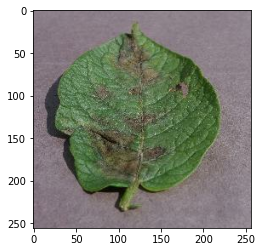

In [25]:
for image_batch,labels_batch in dataset.take(1):
    img= image_batch[0].numpy().astype("uint8")
    label=labels_batch[0].numpy()
    plt.imshow(img)
    print("Actual Label : ",class_names[labels_batch[0].numpy()])
    
    batch_prediction= model.predict(image_batch)
    print("Predicted Label : ",class_names[np.argmax(batch_prediction[0])])

In [26]:

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

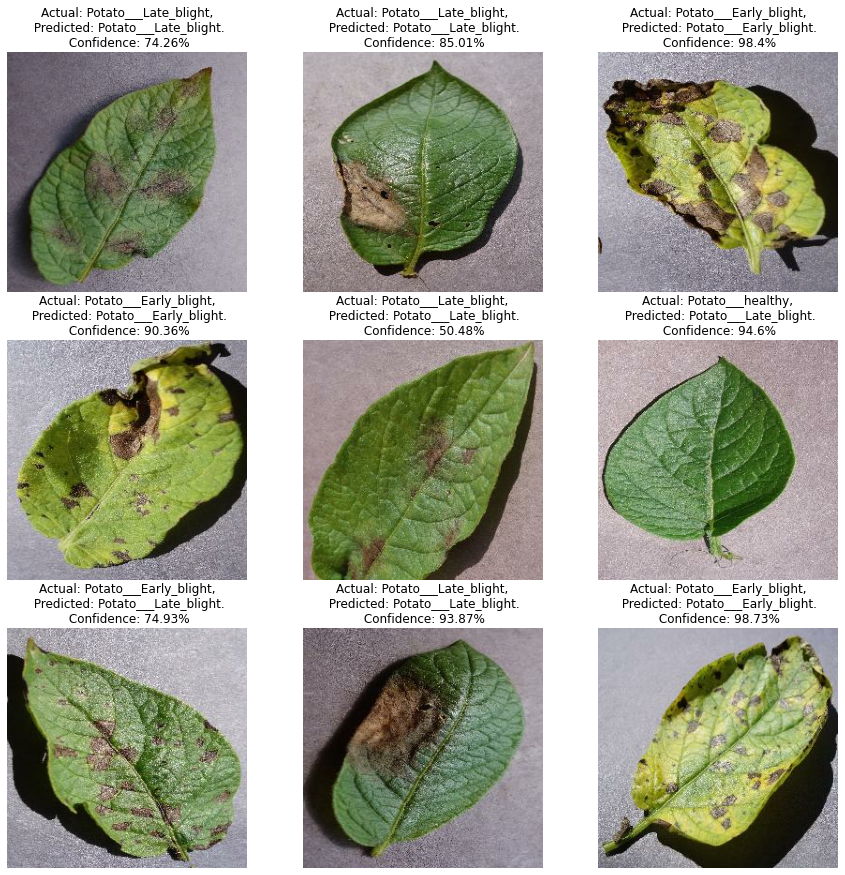

In [27]:

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [28]:
model.save("./potatoes.h5")

# model_version=max([int(i) for i in os.listdir("./model") + [0]])+1
# model.save(f"./model/{model_version}")

In [29]:
# 
# model_version=max([int(i) for i in os.listdir("../model") + [0]])+1

In [30]:
# os.listdir("./model")